In [1]:
from AC import preproc
from AC import get_news
import inspect
import nltk
nltk.download("stopwords")

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
economia = get_news("../articoli_economia/")
cultura = get_news("../articoli_cultura/")
tech = get_news("../articoli_tech/")
politica = get_news("../articoli_politica/")
sport = get_news("../articoli_sport/")
cronaca = get_news("../articoli_cronaca/")

for articolo in economia:
    articolo['categoria'] = "Economia"
for articolo in cultura:
    articolo['categoria'] = "Cultura"
for articolo in tech:
    articolo['categoria'] = "Tech"
for articolo in politica:
    articolo['categoria'] = "Politica"
for articolo in sport:
    articolo['categoria'] = "Sport"
for articolo in cronaca:
    articolo['categoria'] = "Cronaca"
dati_preprocessati =  preproc(tech + politica + cultura + economia + sport + cronaca)

100%|██████████| 2400/2400 [02:41<00:00, 14.90it/s]


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid

import numpy as np
import pandas as pd
import math

import tqdm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import linear_model,metrics
from AC import grafico_metrica_iperparametri

In [4]:
seed = 0
train_documents,test_documents = train_test_split(dati_preprocessati,random_state=seed,train_size=0.5)
test_documents, val_documents = train_test_split(test_documents,random_state=seed,train_size=0.5)

/home/alex/anaconda3/envs/msbd/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
docs_texts = [' '.join([word for word in x['testo']] + x['tags'] + x['sottotitolo'] + x['titolo_articolo']) for x in dati_preprocessati]
train_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in train_documents]
test_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in test_documents]
val_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in val_documents]

docs_cats = [x["categoria"] for x in dati_preprocessati]
train_cats = [x["categoria"] for x in train_documents]
test_cats = [x["categoria"] for x in test_documents]
val_cats = [x["categoria"] for x in val_documents]

# Ottimizzazione con LDA, 12 componenti

In [6]:
params_tdm = {
    'ngram_range': (1, 3),
    'min_df': 9,
    'max_df': 0.5
}

params_lda = {
    'n_components':12,
    'learning_decay':0.7    
}

tf = CountVectorizer(max_features=1000000, lowercase=True, **params_tdm).fit(train_texts)
tf_train = tf.transform(train_texts)
ldax = LatentDirichletAllocation(max_iter=50, learning_method='online', random_state=0, **params_lda).fit(tf_train.toarray())
ldax_train = ldax.transform(tf_train.toarray())
tf_val = tf.transform(val_texts)
ldax_val = ldax.transform(tf_val.toarray())

ldac = DecisionTreeClassifier(random_state=0)
ldac.fit(ldax_train, train_cats)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [7]:
n = ldac.tree_.max_depth
print("Profondità dell'albero allenato senza restrizioni: {}".format(ldac.tree_.max_depth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(len(ldax_train) // 2))

Profondità dell'albero allenato senza restrizioni: 18
Massimo numero minimo di osservazioni in una foglia: 600


In [8]:
param_grid = ParameterGrid({
    'max_depth': np.arange(1, n+1),
    'min_samples_leaf': 2 ** np.arange(int(math.log(len(ldax_train) // 2,2))),
})
print(param_grid.param_grid)

[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18]), 'min_samples_leaf': array([  1,   2,   4,   8,  16,  32,  64, 128, 256])}]


In [9]:
risultati = []
for params in tqdm.tqdm(param_grid):
    ldac = DecisionTreeClassifier(random_state=0, **params).fit(ldax_train, train_cats)
    y_pred = ldac.predict(ldax_val)
    params["accuracy_score"] = metrics.accuracy_score(val_cats, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|██████████| 162/162 [00:03<00:00, 43.25it/s]

Primi 5:


,accuracy_score,max_depth,min_samples_leaf
0,0.991667,18,1
1,0.990000,16,1
2,0.990000,17,1
3,0.983333,15,1
4,0.981667,14,1


Ultimi 5:


,accuracy_score,max_depth,min_samples_leaf
157,0.320000,2,16
158,0.320000,2,32
159,0.320000,2,64
160,0.320000,2,128
161,0.256667,1,256


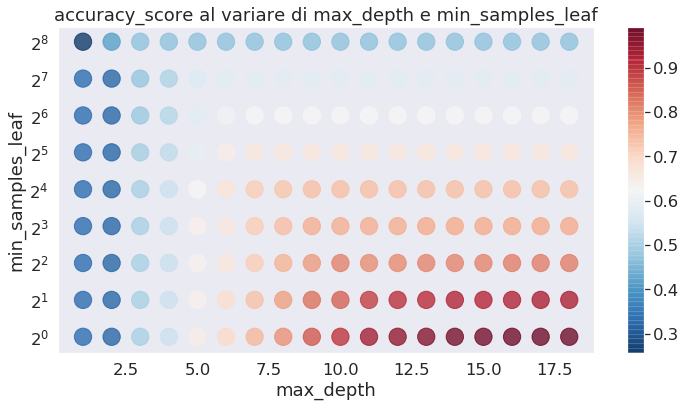

In [12]:
plt.figure(figsize=(12, 6))

grafico_metrica_iperparametri(risultati, "max_depth", "min_samples_leaf", "accuracy_score")
plt.yscale("log", basey=2)

plt.show()

# Ottimizzazione con LDA, 48 componenti

In [13]:
params_tdm = {
    'ngram_range': (1, 3),
    'min_df': 9,
    'max_df': 0.5
}

params_lda = {
    'n_components':48,
    'learning_decay':0.7    
}

tf = CountVectorizer(max_features=1000000, lowercase=True, **params_tdm).fit(train_texts)
tf_train = tf.transform(train_texts)
ldax = LatentDirichletAllocation(max_iter=50, learning_method='online', random_state=0, **params_lda).fit(tf_train.toarray())
ldax_train = ldax.transform(tf_train.toarray())
tf_val = tf.transform(val_texts)
ldax_val = ldax.transform(tf_val.toarray())

ldac = DecisionTreeClassifier(random_state=0)
ldac.fit(ldax_train, train_cats)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [14]:
n = ldac.tree_.max_depth
print("Profondità dell'albero allenato senza restrizioni: {}".format(ldac.tree_.max_depth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(len(ldax_train) // 2))

Profondità dell'albero allenato senza restrizioni: 23
Massimo numero minimo di osservazioni in una foglia: 600


In [15]:
param_grid = ParameterGrid({
    'max_depth': np.arange(1, n+1),
    'min_samples_leaf': 2 ** np.arange(int(math.log(len(ldax_train) // 2,2))),
})
print(param_grid.param_grid)

[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23]), 'min_samples_leaf': array([  1,   2,   4,   8,  16,  32,  64, 128, 256])}]


In [16]:
risultati = []
for params in tqdm.tqdm(param_grid):
    ldac = DecisionTreeClassifier(random_state=0, **params).fit(ldax_train, train_cats)
    y_pred = ldac.predict(ldax_val)
    params["accuracy_score"] = metrics.accuracy_score(val_cats, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|██████████| 207/207 [00:12<00:00, 17.13it/s]

Primi 5:


,accuracy_score,max_depth,min_samples_leaf
0,0.980000,23,1
1,0.978333,22,1
2,0.975000,21,1
3,0.973333,20,1
4,0.970000,19,1


Ultimi 5:


,accuracy_score,max_depth,min_samples_leaf
202,0.198333,1,4
203,0.198333,1,8
204,0.198333,1,16
205,0.198333,1,32
206,0.198333,1,64


# Ottimizzazione senza LDA

In [17]:
params_tdm = {
    'ngram_range': (1, 3),
    'min_df': 9,
    'max_df': 0.5
}

tf = CountVectorizer(max_features=1000000, lowercase=True, **params_tdm).fit(train_texts)
tf_train = tf.transform(train_texts)
tf_val = tf.transform(val_texts)

tfc = DecisionTreeClassifier(random_state=0)
tfc.fit(tf_train.toarray(), train_cats)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [18]:
m = tfc.tree_.max_depth
print("Profondità dell'albero allenato senza restrizioni: {}".format(tfc.tree_.max_depth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(len(tf_train.toarray()) // 2))

Profondità dell'albero allenato senza restrizioni: 38
Massimo numero minimo di osservazioni in una foglia: 600


In [19]:
param_grid = ParameterGrid({
    'max_depth': np.arange(1, m+1),
    'min_samples_leaf': 2 ** np.arange(int(math.log(len(tf_train.toarray()) // 2,2))),
})
print(param_grid.param_grid)

[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38]), 'min_samples_leaf': array([  1,   2,   4,   8,  16,  32,  64, 128, 256])}]


In [20]:
risultati = []
for params in tqdm.tqdm(param_grid):
    tfc = DecisionTreeClassifier(random_state=0, **params).fit(tf_train.toarray(), train_cats)
    y_pred = tfc.predict(tf_val.toarray())
    params["accuracy_score"] = metrics.accuracy_score(val_cats, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|██████████| 342/342 [08:21<00:00,  1.05s/it]

Primi 5:


,accuracy_score,max_depth,min_samples_leaf
0,0.985000,34,1
1,0.985000,35,1
2,0.985000,37,1
3,0.981667,36,1
4,0.981667,38,1


Ultimi 5:


,accuracy_score,max_depth,min_samples_leaf
337,0.178333,1,8
338,0.178333,1,16
339,0.178333,1,32
340,0.178333,1,64
341,0.178333,1,128
